# Mở đầu
Mục đích file .ipynb này là tập implement YOLO với yolov1

Thử tập luyện với bài toán phân biệt hình tròn, hình tam giác và hình chữ nhật

## Import 

In [1]:
pip install --upgrade tf_slim

In [2]:
# slim là 1 package có 1 vài mô hình deep learning như vgg
# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
# debug TFv2 không có placeholder
import tf_slim as slim
from tf_slim.nets import vgg
# cho data
from sklearn.model_selection import train_test_split
import json
# params
import numpy as np
import cv2
# plot
import matplotlib.pyplot as plt
import time


## Setup hyperparams of Yolov1

In [3]:
# image
cell_size = 7
box_per_cell = 2
img_size = 224
box_scale = 5.0
noobject_scale = 0.5

# train
classes = {'circle' : 0, 'triangle' : 1, 'rectangle' : 2}
nclass =len(classes)

batch_size = 120
epochs = 10
lr = 0.001


## Load data
Chúng ta có 25k mẫu dữ liệu, mỗi ảnh có kích thước 224x224, và một file json chứa nhãn của các ảnh, gồm tập các object tương ứng với vị trí tạo độ của boundary box chứa object.

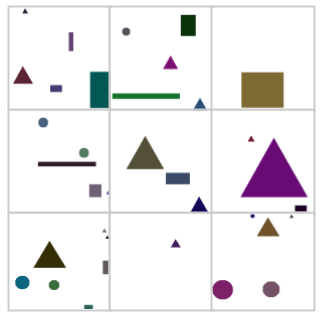

In [4]:
!wget --quiet --no-check-certificate 'https://docs.google.com/uc?export=download&id=12sZLOe5VDvAqGHcjJh7mVmjB6HPeIEJh' -O train.zip
# --quiet để không hiện output
# --no-check-certificate dành cho các trang có sercurity (https)
# -0 output vào 1 file
!unzip -o -q train.zip
#-q quite -o vào 1 file
!ls train | head
# để check status file


Viết hàm ghép data với nhãn tương ứng trong file train/labels.json

In [5]:
def load():
  labels = json.load(open('train/labels.json'))
  N = len(labels)
  # khởi tạo khung matrix
  X = np.zeros((N, img_size, img_size, 3), dtype = 'uint8') #3 là BGR
  y = np.zeros((N, cell_size, cell_size, 5 + nclass)) # 5+nclass là 5 hệ số được dự đoán + C
  for idx, label in enumerate(labels):
    img = cv2.imread("train/{}.png".format(idx))
    # normalize data
    X[idx] = img
    for box in label['boxes']:
      x1, x2 = box['x1'], box['x2']
      y1, y2 = box['y1'], box['y2']
      #vector xem có phải object có thể thuộc class nào
      cl = [0] * len(classes)
      cl[classes[box['class']]] = 1
      # các biến coordination
      x_center, y_center, w, h = (x1+x2) / 2.0, (y1+y2) / 2.0, x2 - x1, y2 - y1
      # xác định grid cell chứa tâm
      x_idx, y_idx = int(x_center / img_size * cell_size), int(y_center / img_size * cell_size)
      # ghép label
      y[idx, y_idx, x_idx] = 1, x_center, y_center, w, h, *cl # 5+nclass
  return X,y

Chia tập test

In [6]:
X, y = load()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 2022)

## Chọn mô hình CNN
Tiếp theo ta cần chọn mô hình CNN để cho ra ouyput cà shape phù hợp (grid_size x grid_size x (5*nbox+nclass) với grid_size đã chọn là 7. Vậy ta cần kích thước 448x448. Thay vì sử dụng full connected ở các tầng cuối cùng, ta có thể thay bằng tầng 1x1 convolution với 13 features để ra 7x7x13

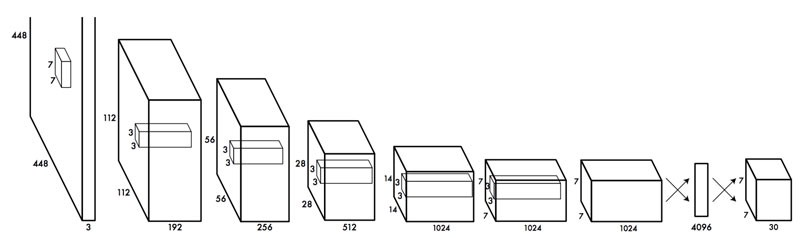

Ta nghĩ đến VGG16 như 1 trong những model phù hợp


In [7]:
def vgg16(inputs, is_training):
  """
  input: 5D tensor [batch_size, width, height, 3]
  output: 4D tensor [batch_size, 7, 7, 5*nbox + nclass]
  """
  # khai báo scope để dễ visualize trên tensorboard
  with tf.variable_scope("vgg_16"):
    with slim.arg_scope(vgg.vgg_arg_scope()):
      # hàm repeat có tác dụng lặp lại tầng conv2d n lần
      net = slim.repeat(inputs, 2, slim.conv2d, 16, [3, 3], scope = 'conv1')
      net = slim.max_pool2d(net, [2, 2], scope = 'pool1')
      net = slim.repeat(net, 2, slim.conv2d, 32, [3, 3], scope = 'conv2')
      net = slim.max_pool2d(net, [2, 2], scope = 'pool2')
      net = slim.repeat(net, 2, slim.conv2d, 64, [3, 3], scope = 'conv3')
      net = slim.max_pool2d(net, [2, 2], scope = 'pool3')
      net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope = 'conv4')
      net = slim.max_pool2d(net, [2, 2], scope = 'pool4')
      net = slim.repeat(net, 2, slim.conv2d, 256, [3, 3], scope = 'conv5')
      net = slim.max_pool2d(net, [2, 2], scope = 'pool5')
      
      # thay vì sử dụng 2 Fully conected layer FC, ta dùng conv với kernel 1x1 với tác dụng tương đương
      net = slim.conv2d(net, 512, [1, 1], scope = 'fc6')
      net = slim.conv2d(net, 13, [1, 1], activation_fn=None, scope='fc7')
  return net

## Hàm tính IOU
Ta cần xây dựng hàm tính Intersection Over Union IOU để lấy này làm 1 trong những thành phàn tính sai số

In [8]:
def compute_iou(boxes1, boxes2, scope='iou'):
  """
  input: boxes1, boxes2: 5D tensor [batch_size, cell_size, cell_size, boxes_per_cell, 4]
  output: 4D tensor [batch_size, cell_size, cell_size, boxes_per_cell]
  """
  with tf.variable_scope(scope):
    #transform (x_center, y_center, w, h) về (x1, y1, x2, y2)
    boxes1_transformed = tf.stack([boxes1[..., 0] - boxes1[..., 2] / 2.0,
                                   boxes1[..., 1] - boxes1[..., 3] / 2.0,
                                   boxes1[..., 0] + boxes1[..., 2] / 2.0,
                                   boxes1[..., 1] + boxes1[..., 3] / 2.0],
                                  axis = -1) # axis là hướng xếp matrix
    boxes2_transformed = tf.stack([boxes2[..., 0] - boxes2[..., 2] / 2.0,
                                   boxes2[..., 1] - boxes2[..., 3] / 2.0,
                                   boxes2[..., 0] + boxes2[..., 2] / 2.0,
                                   boxes2[..., 1] + boxes2[..., 3] / 2.0],
                                  axis = -1)
    
    # tính góc trên bên trái và góc dưới bên phải
    leftup = tf.maximum(boxes1_transformed[..., :2], boxes2_transformed[..., :2])
    rightdown = tf.maximum(boxes1_transformed[..., 2:], boxes2_transformed[..., 2:])
    
    # tính intersection
    intersection = tf.maximum(0.0, rightdown - leftup)
    inter_square = intersection[..., 0] * intersection[..., 1]

    # tính Union square
    square1 = boxes1[..., 2] * boxes1[..., 3]
    square2 = boxes2[..., 2] * boxes2[..., 3]
    union_square = tf.maximum(square1 + square2 - inter_square, 1e-10)
  return tf.clip_by_value(inter_square / union_square, 0.0, 1.0)

## Loss function
YOLO sử dụng hàm độ lỗi bình phương giữ dự đoán và nhãn để tính độ lỗi cho mô hình. Cụ thể, độ lỗi tổng của chúng ta sẽ là tổng của 3 độ lỗi con sau:

- Độ lỗi của việc dữ đoán loại nhãn của object - Classifycation loss
- Độ lỗi của dự đoán tạo độ cũng như chiều dài, rộng của boundary box - Localization loss
- Độ lỗi của ô vuông có chứa object nào hay không - Confidence loss

### Classification Loss
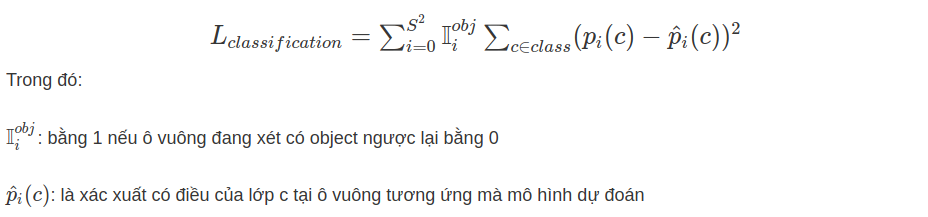
### Localization Loss
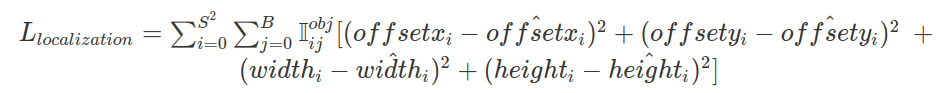
### Confidence Loss
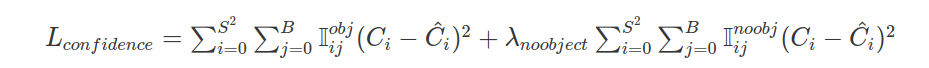
### Total Loss
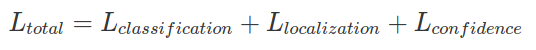

In [9]:
def loss_layer(predicts, labels, scope='loss_layer'):
  """
  input: 
    predicts: 4D tensor [batch_size, 7, 7, 5 * nbox + n_class]
    labels: 4D tensor [batch_size, 7, 7, 5 + n_class]
  output:
    loss: scalar
  """
  with tf.variable_scope(scope):
    offset = np.transpose(np.reshape(np.array(
        [np.arange(cell_size)] * cell_size * box_per_cell),
        (box_per_cell, cell_size, cell_size)), (1, 2, 0))
    offset = offset[None, :]
    offset = tf.constant(offset, dtype = tf.float32)
    offset_transpose = tf.transpose(offset, (0, 2, 1, 3))

    # 2 phần tử đầu để dự đoán confidence score:
    predict_object = predicts[..., :box_per_cell]
    # 8 phần tử tiếp theo à 4x2 dự đoán các thống số của boundary box
    predict_box_offset = tf.reshape(predicts[..., box_per_cell:5*box_per_cell], (-1, cell_size, cell_size, box_per_cell, 4))
    # các phần tử cuối là dự đoán classification
    predict_class = predicts[..., 5 * box_per_cell:]

    # normalize tọa độ
    predict_normalized_box = tf.stack([(predict_box_offset[..., 0] + offset) / cell_size,
                                       (predict_box_offset[..., 1] + offset_transpose) / cell_size,
                                       tf.square(predict_box_offset[..., 2]),
                                       tf.square(predict_box_offset[..., 3])], axis= -1)
    # lấy label tương ứng 
    true_object = labels[..., :1]
    true_box = tf.reshape(labels[..., 1:5], (-1, cell_size, cell_size, 1, 4))
    #normalize tọa độ
    true_normalized_box = tf.tile(true_box, (1, 1, 1, box_per_cell, 1)) / img_size
    true_class = labels[..., 5:]
    true_box_offset = tf.stack([true_normalized_box[..., 0] * cell_size - offset,
                                true_normalized_box[..., 1] * cell_size - offset_transpose,
                                tf.sqrt(true_normalized_box[..., 2]),
                                tf.sqrt(true_normalized_box[..., 3])], axis = -1)
    
    # tính IOU
    predict_iou = compute_iou(true_normalized_box, predict_normalized_box)

    # ghi lại (mask) vị trí các ô chứa object (có là 1 không là 0)
    object_mask = tf.reduce_max(predict_iou, 3, keepdims = True)

    # tính metric để monitoring (giám sát)
    iou_metric = tf.reduce_mean(tf.reduce_sum(object_mask, axis = [1, 2, 3]) / tf.reduce_sum(true_object, axis = [1, 2, 3]))
        
    object_mask = tf.cast((predict_iou >= object_mask), tf.float32) * true_object
    
    noobject_mask = tf.ones_like(object_mask) - object_mask

    # classification loss
    class_delta = true_object * (predict_class - true_class)
    class_loss = tf.reduce_mean(tf.reduce_sum(tf.square(class_delta), axis = [1, 2, 3]), name = 'class_loss')

    # confidence loss
    # object loss
    object_delta = object_mask * (predict_object - predict_iou)
    object_loss = tf.reduce_mean(tf.reduce_sum(tf.square(object_delta), axis = [1, 2, 3]), name = 'object_loss')
    # noobject loss
    noobject_delta = object_mask * predict_object
    noobject_loss = tf.reduce_mean(tf.reduce_sum(tf.square(noobject_delta), axis = [1, 2, 3]), name = 'noobject_loss')
    
    # localization loss
    box_mask = tf.expand_dims(object_mask, 4)
    box_delta = box_mask * (predict_box_offset - true_box_offset)
    box_loss = tf.reduce_mean(tf.reduce_sum(tf.square(box_delta), axis = [1, 2, 3]), name = 'box_loss')

    total_loss = 0.5*class_loss + object_loss + 0.1*noobject_loss + 10*box_loss
    # class_loss nên là 0.5 để tránh bias
    # boject_loss quan trọng hơn nhiều noobject_loss
    #box_loss là iou nên trị số có thể rất nhỏ

    return total_loss, iou_metric, predict_object, predict_class, predict_normalized_box
         

# Graph và Optimizer


In [10]:
graph = tf.Graph()
with graph.as_default():
  # đặt batch_size là None trước để dễ đổi ở sau
  images = tf.placeholder("float", [None, img_size, img_size, 3], name="input") 
  labels = tf.placeholder("float", [None, cell_size, cell_size, 8], name = "label")
  is_training = tf.placeholder(tf.bool)

  logits = vgg16(images, is_training)
  loss, iou_metric, predict_object, predict_class, predict_normalized_box = loss_layer(logits, labels)

  # định nghĩa optimizer để tối ưu hàm loss
  optimizer = tf.train.AdamOptimizer(lr)
  train_op = optimizer.minimize(loss)

# Training
giá trị IOU càng gần 1 thì càng tốt

In [11]:
with tf.Session(graph = graph) as sess:
  sess.run(tf.global_variables_initializer())

  # định nghĩa saver lại các trọng số để dùng cho ảnh mới
  saver = tf.train.Saver(max_to_keep = 1)
  
  #training
  for epoch in range(epochs):
    start_time = time.time()
    for batch in range(len(X_train)//batch_size):
      # lấy theo từng batch, forward, backward, cập nhật theo adam optimizer
      X_batch = X_train[batch*batch_size:(batch+1)*batch_size]
      y_batch = y_train[batch*batch_size:(batch+1)*batch_size]
      train_total_loss, train_iou_m,_ = sess.run([loss, iou_metric, train_op], {images:X_batch, labels:y_batch, is_training:True})            
    end_time = time.time()

    #tính loss, iou trên tập validation
    val_loss = []
    val_iou_ms = []
    for batch in range(len(X_test)//batch_size):
      val_X_batch = X_test[batch*batch_size:(batch+1)*batch_size]
      val_y_batch = y_test[batch*batch_size:(batch+1)*batch_size]
      total_val_loss, val_iou_m, val_predict_object, val_predict_class, val_predict_normalized_box = sess.run([loss, iou_metric, predict_object, predict_class, predict_normalized_box], 
                                                 {images:val_X_batch, labels:val_y_batch, is_training:False})
      val_loss.append(total_val_loss)
      val_iou_ms.append(val_iou_m)
            
    saver.save(sess, './model/yolo', global_step=epoch)
    print('epoch: {} - running_time: {:.0f}s - train_loss: {:.3f} - train_iou: {:.3f} - val_loss: {:.3f} - val_iou: {:.3f}'.format(epoch, end_time - start_time, train_total_loss, train_iou_m, np.mean(val_loss), np.mean(val_iou_ms)))

          
        

Nếu chạy bằng GPU của Kaggle
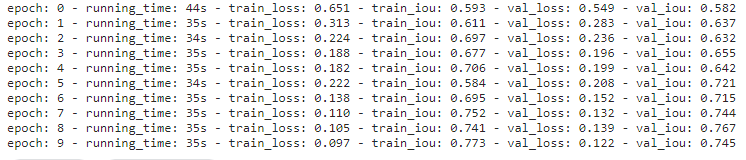

# Hiển thị kết quả
Filter tất cả các box không thỏa điều kiện chứa object

Merge các box có overlap nhiều

In [12]:
def iou(box1, box2):
  """
  tính iou bằng numpy
  input: box1, box2 : [center_x, center_y, w, h]
  output: iou
  """
  tb = min(box1[0] + 0.5 * box1[2], box2[0] + 0.5 * box2[2]) - max(box1[0] - 0.5 * box1[2], box2[0] - 0.5 * box2[2]) # theo trục x
  lr = min(box1[1] + 0.5 * box1[3], box2[1] + 0.5 * box2[3]) - max(box1[1] - 0.5 * box1[3], box2[1] - 0.5 * box2[3]) # theo trục y
  
  inter = 0 if tb < 0 or lr < 0 else tb * lr
  return inter / (box1[2] * box1[3] + box2[2] * box2[3] - inter) #lấy tỉ lệ

### non-maximun suppression

In [28]:
def interpret_output(predict_object, predict_class, predict_normalized_box):
  predict_box = predict_normalized_box * img_size # để có không gian pixel
  predict_object = np.expand_dims(predict_object, axis = -1)
  predict_class = np.expand_dims(predict_class, axis = -2)
  # xác suất đúng class = xác suất boundary box chứa object * xác suất object thuộc class
  class_probs = predict_object * predict_class

  #đặt threshold là 0.2, chỉ giữ lại các xác suất dự đoán lớp lớn hơn
  filter_mat_probs = np.array(class_probs >= 0.2, dtype = 'bool')
  filter_mat_boxes = np.nonzero(filter_mat_probs)
  boxes_filtered = predict_box[filter_mat_boxes[0], filter_mat_boxes[1], filter_mat_boxes[2]]
  class_probs_filtered = class_probs[filter_mat_probs]

  #chọn index của class có xác suất lớn nhất tại mỗi boundary box
  classes_num_filtered = np.argmax(filter_mat_probs, axis = 3)[filter_mat_boxes[0], filter_mat_boxes[1], filter_mat_boxes[2]]
  # chỉ giữ lại boundary box có xác suất lớn nhất
  argsort = np.array(np.argsort(class_probs_filtered))[::-1]
  boxes_filtered = boxes_filtered[argsort]
  class_probs_filtered = class_probs_filtered[argsort]
  classes_num_filtered = classes_num_filtered[argsort]

  # vòng lặp non_maximun suppression
  for i in range(len(boxes_filtered)):
    if class_probs_filtered[i] == 0:
      continue
    for j in range(i + 1, len(boxes_filtered)):
      if iou(boxes_filtered[i], boxes_filtered[j]) > 0.5:
        class_probs_filtered[j] = 0.0
  # bỏ những boundary overlap
  filter_iou = np.array(class_probs_filtered > 0.0, dtype = 'bool')
  boxes_giltered = boxes_filtered[filter_iou]
  class_probs_filtered = class_probs_filtered[filter_iou]
  classes_num_filtered = classes_num_filtered[filter_iou]

  result = []
  for i in range(len(boxes_filtered[i])):
    result.append([classes_num_filtered[i], boxes_filtered[i][0], boxes_filtered[i][1], boxes_filtered[i][2], boxes_filtered[i][3], class_probs_filtered[i]])
  return result


### Hiện kết quả


In [35]:
def draw_result(img, result):
  """
  input: img
  output: hiện các thông số của result từ hàm unterpret_output
  """
  plt.figure(figsize = (10, 10), dpi = 40)
  img = np.pad(img, [(50, 50), (50, 50), (0, 0)], mode = 'constant', constant_values = 255)
  for i in range(len(result)):
    x = int(result[i][1]) + 50
    y = int(result[i][2]) + 50
    w = int(result[i][3] / 2)
    h = int(result[i][4] / 2)
    cv2.rectangle(img, (x - w, y - h), (x + w, y + h), (231, 76, 60), 2)
    cv2.rectangle(img, (x - w, y - h - 20), (x - w + 50, y - h - 7), (46, 204, 113), -1)
    cv2.putText(img, '{} : {:.2f}'.format(result[i][0], result[i][5]), (x - w + 5, y - h - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 0), 1, cv2.LINE_AA)
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])

thử với 1 ảnh mẫu

In [38]:
img_idx = 21
result = interpret_output(val_predict_object[img_idx], val_predict_class[img_idx], val_predict_normalized_box[img_idx])


In [39]:
draw_result(val_X_batch[img_idx] * 255, result)